# LAB 04 Assigment

Dominik Breksa (dominikbreksa@student.agh.edu.pl)

In [1]:
import numpy as np;import pint;import scipy;import matplotlib.pyplot as plt;from open_atmos_jupyter_utils import show_plot;from functools import partial;from typing import Final;plt.rcParams['axes.grid'] = True;si = pint.UnitRegistry();si.setup_matplotlib()

### Physical Problem Definition

The physical problem that I will model today is the temperature of the fluid (water) with convective and conductive heat transfer in one-dimensional spacial domain.

To solve this problem, I will use the advection-diffusion parabolic partial differential equation (also called in our case simplified convection-conduction equation).

$$
\frac{\partial \psi}{\partial t} + u \frac{\partial \psi}{\partial x} - \mu \frac{\partial ^ 2 \psi}{\partial^2 x} = 0
$$

where,

- $t$ - time in seconds $[s]$,
- $x$ - spacial domain $[m]$,
- $\psi(x, t)$ - It is the function of temperature at a given point in one-dimensional space and time $[K]$,
- $u$ - Convection coefficient of the flow $[\frac{m}{s}]$,
- $\mu$ - Conduction coefficient $[\frac{m^2}{s}]$,
- $u \frac{\partial \psi}{\partial x}$ - Transport of heat by convection,
- $- \mu \frac{\partial ^ 2 \psi}{\partial^2 x}$ - Diffusive term which in our case is heat conduction.

##### Boundary conditions — that my model uses

1. Left boundary condition, for example, for $\psi(x=0, t)$:

    $$
    \psi(x, t) = \psi_L(t) = T_o \qquad (t \ge 0; x \le 0)
    $$

2. Right boundary condition, for example, for $\psi(x=20, t)$:

    $$
    \psi(x, t) = \psi_R(t) = T_i \qquad (t \ge 0; x \ge 1)
    $$

The values of $T_o$ and $T_i$ are constant in time and space, and for my example are equal to $T_o = 50^\circ C$, $T_i = 0^\circ C$.

##### Initial conditions — that my model uses:

$$
\psi(x, 0) = \psi_0(x) = T_i \qquad (0 \le x \le 1)
$$

In [2]:
X_0: Final = np.float64(0.0)
X_N: Final = np.float64(20.0)
NUM_X: Final = np.uint32(1000)

X, DX = np.linspace(X_0, X_N, num=NUM_X, dtype=np.float64, retstep=True, endpoint=True)
DX *= si.m
X *= si.m

In [3]:
T_0: Final = np.float64(0.0)
T_N: Final = np.float64(14.0)
NUM_T: Final = np.uint32(14000)

T, DT = np.linspace(T_0, T_N, num=NUM_T, dtype=np.float64, retstep=True, endpoint=True)
DT *= si.s
T *= si.s

### Analytical solution

The Proof to my analytical solution, given these initial and boundary conditions, can be found here: [SOURCE](https://www.youtube.com/watch?v=Jr3aOildCCA)

$$
\psi(x, t) = \frac{T_o + T_i}{2} - \frac{T_o - T_i}{2} erf(\frac{x - ut}{2 \sqrt{t\mu}})
$$

After that, I will implement the solution as Python functions.

In [4]:
def initial_conditions(t_o, t_i, x):
    return np.where(x < 0, t_o, t_i)

def left_boundary_conditions(t_o, t):
    return np.full_like(t, t_o)

def right_boundary_conditions(t_i, t):
    return np.full_like(t, t_i)

def analytic_solution(t_o, t_i, u, mu, x, t):
    # pint 'Quantity' class does not work with 'scipy.special.erf(...)' :) Valve please fix!
    return (t_o + t_i - (t_o - t_i) * scipy.special.erf(((x - u * t) / np.sqrt(t) / 2. / mu).magnitude)) / 2

In [5]:
TEMPERATURE_O: Final = np.float64(50.0 + scipy.constants.zero_Celsius) * si.K
TEMPERATURE_I: Final = np.float64(0.0 + scipy.constants.zero_Celsius) * si.K

In [6]:
U: Final = np.float64(10. ** -6.) * si.m / si.s

All values below are measured at the pressure of $0.1 MPa$ at the temperature of around $25^\circ C$.

- $K_w$ - is the thermal conductivity of water equal to: $0.60719479404817 [\frac{W}{m K}]$,
- $\rho_w$ - is the density of water equal to: $997.0474354081 [\frac{kg}{m^3}]$,
- $c_w$ - is the heat capacity of water at constant pressure equal to: $4181.9000614923 [\frac{J}{kg K}]$.

In [7]:
MU: Final = ((0.60719479404817 * si.W / si.m / si.K) / (997.0474354081 * si.kg / si.m ** 3) / (4181.9000614923 * si.J / si.kg / si.K)).to_base_units()
MU

<Quantity(1.45625882e-07, 'meter ** 2 / second')>

Since the analytic solution function with realworld values of $u$ and $\mu$ is no fun, because it looks very similar to very slow moving initial conditions (rectangle function). I propose to introduce new constant $u_{100000}$ and $\mu_{100000}$ that are just the same constants, but are 100 thousand times greater (the time does not need to be absurd :)).

In [8]:
U_100000: Final = U * 10 ** 6
U_100000

<Quantity(1.0, 'meter / second')>

In [9]:
MU_100000: Final = MU * 10 ** 6
MU_100000

<Quantity(0.145625882, 'meter ** 2 / second')>

In [10]:
INITIAL_CONDITIONS = partial(initial_conditions, TEMPERATURE_O, TEMPERATURE_I)
LEFT_BOUNDARY_CONDITIONS = partial(left_boundary_conditions, TEMPERATURE_O)
RIGHT_BOUNDARY_CONDITIONS = partial(right_boundary_conditions, TEMPERATURE_I)
ANALYTIC_SOLUTION = partial(analytic_solution, TEMPERATURE_O, TEMPERATURE_I, U_100000, MU_100000)

### Numerical solution

To solve the equation numerically, I will use the first order explicit upwind finite difference scheme for the advection-diffusion equation. [SOURCE](https://www.youtube.com/watch?v=UM0o0ToluY8)

Here I provide how I approximated the differences in the advection-diffusion equation:

1. The approximation of $\frac{\partial \psi}{\partial t}$ (first order approximation from Taylor series):

    $$
    \frac{\partial \psi}{\partial t} \approx \frac{\psi_x^{t+1} - \psi_x^t}{\Delta t}
    $$

2. The approximation of $\frac{\partial ^ 2 \psi}{\partial^2 x}$ (second order approximation from Taylor series):

    $$
    \frac{\partial ^ 2 \psi}{\partial^2 x} \approx \frac{\psi_{x-1}^t - 2 \psi_x^t + \psi_{x+1}^t}{\Delta x^2}
    $$

3. The approximation of $\frac{\partial \psi}{\partial x}$ (first order approximation from Taylor series and Upwind):

    $$
    \frac{\partial \psi}{\partial x} \approx \frac{\psi_x^t - \psi_{x-1}^t}{\Delta x} \qquad (u \gt 0)
    $$

    $$
    \frac{\partial \psi}{\partial x} \approx \frac{\psi_{x+1}^t - \psi_x^t}{\Delta x} \qquad (u \lt 0)
    $$

After using the approximations defined above, we get the following upwind equations (where the Courant number is: $C = u\frac{\Delta t}{\Delta x}$ and the Fourier number is: $F = \mu\frac{\Delta t}{\Delta x^2}$):

1. For $(u \ge 0)$:

    $$
    \psi_i^{j+1} = (C + F)\psi_{i-1}^j + (1 - 2F - C) \psi_i^j + F \psi_{i+1}^j
    $$

2. For $(u \lt 0)$:

    $$
    \psi_i^{j+1} = F\psi_{i-1}^j + (1 - 2F + C) \psi_i^j + (C + F)\psi_{i+1}^j
    $$

In [11]:
def numerical_solution(x, t, dx, dt, u, mu, initial_condition, left_boundary_condition, right_boundary_condition):
    c = u * dt / dx; f = mu * dt / dx / dx

    left_fill = np.zeros(shape=(len(x),), dtype=x.dtype)
    right_fill = np.zeros(shape=(len(x),), dtype=x.dtype)

    # Upwind condition
    a = np.diag(np.full((len(x) - 1,), (c + f) if c >= 0 else f), k=-1) + \
        np.diag(np.full((len(x) - 1,), f if c >= 0 else (c + f)), k=1) + \
        np.diag(np.full((len(x),), (1 - f - f - c) if c >= 0 else (1 - f - f + c)))

    # The convergence condition
    assert (spectral_radius := np.max(np.abs(np.linalg.eigvals(a)))) <= 1., f'{spectral_radius=} must be less or equal to 1 to perform stable calculations'

    left_fill[0] = c + f if c >= 0 else f
    right_fill[-1] = f if c >= 0 else c + f

    a = np.append(np.expand_dims(left_fill, axis=-1), a, axis=1)
    a = np.append(a, np.expand_dims(right_fill, axis=-1), axis=1)
    init_vec = initial_condition(x)
    out = np.zeros(shape=(len(x) + 2, len(t)), dtype=x.dtype) * init_vec.units

    out[1: -1, 0] = init_vec
    out[0, :] = left_boundary_condition(t)
    out[-1, :] = right_boundary_condition(t)

    for j in range(1, len(t)):
        out[1: -1, j] = np.matmul(a, out[:, j - 1].T)

    return out

In [12]:
NUMERICAL_SOLUTION = numerical_solution(x=X, t=T, dx=DX, dt=DT, u=U_100000, mu=MU_100000, initial_condition=INITIAL_CONDITIONS, left_boundary_condition=LEFT_BOUNDARY_CONDITIONS, right_boundary_condition=RIGHT_BOUNDARY_CONDITIONS)

### Comparison of analytic and numerical solutions — Root Mean Square Error

Root Mean Square Error is a measure of error between two vectors ($x^{pred}$ (the predicted vector) and $x^{true}$ (the actual vector)) of size $N$.

The function from above can be implemented as a Python function over vectors (copied and pasted from a previous lab):

In [13]:
def root_mean_square_error(x_pred, x_true):
    assert x_pred.shape == x_true.shape, f'{x_pred.shape=} != {x_true.shape=}, The input vectors have different shapes'

    return np.sqrt(np.mean((x_pred - x_true) ** 2))

In [14]:
ERROR_RATE_PER_TIME_STEP = np.zeros(shape=(len(T),), dtype=X.dtype) * TEMPERATURE_I.units

for i in range(1, NUM_T):
    ERROR_RATE_PER_TIME_STEP[i] = root_mean_square_error(NUMERICAL_SOLUTION[1:-1, i], ANALYTIC_SOLUTION(X, T[i]))

### Plots creation

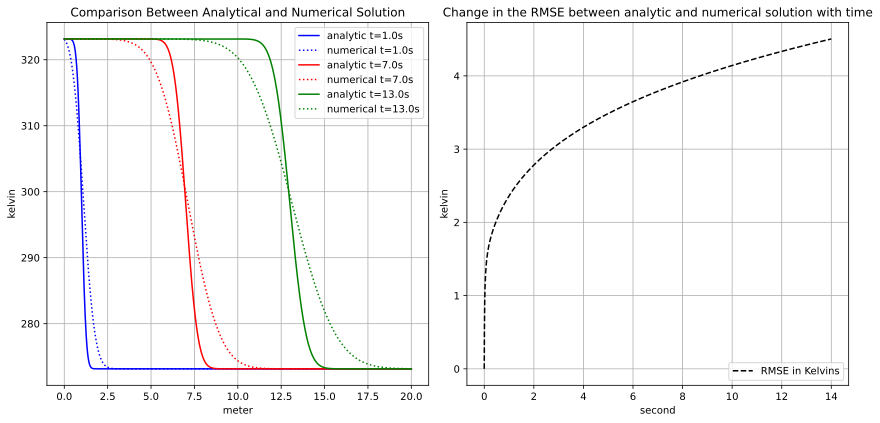

In [21]:
fig = plt.figure(figsize=(12, 6))
ax1, ax2 = fig.subplots(1, 2)

ax1.set_title('Comparison Between Analytical and Numerical Solution')
ax1.plot(X, ANALYTIC_SOLUTION(X, T[1000]), '-b', label=f'analytic t={1000 * T_N / NUM_T}s')
ax1.plot(X, NUMERICAL_SOLUTION[1: -1, 1000], ':b', label=f'numerical t={1000 * T_N / NUM_T}s')
ax1.plot(X, ANALYTIC_SOLUTION(X, T[7000]), '-r', label=f'analytic t={7000 * T_N / NUM_T}s')
ax1.plot(X, NUMERICAL_SOLUTION[1: -1, 7000], ':r', label=f'numerical t={7000 * T_N / NUM_T}s')
ax1.plot(X, ANALYTIC_SOLUTION(X, T[13000]), '-g', label=f'analytic t={13000 * T_N / NUM_T}s')
ax1.plot(X, NUMERICAL_SOLUTION[1: -1, 13000], ':g', label=f'numerical t={13000 * T_N / NUM_T}s')
ax1.legend()

ax2.set_title('Change in the RMSE between analytic and numerical solution with time')
ax2.plot(T, ERROR_RATE_PER_TIME_STEP, '--k', label=f'RMSE in Kelvins')
ax2.legend(loc='lower right')

fig.tight_layout()

show_plot(fig=fig)

### Conclusions

- The Numerical and Analytical solutions are implemented correctly, and the shown curves match the expected results (i.e. The curves are continuous; they have the extremes at the correct place; They change predictably in time (Jugging by mathematical model)).
- On the first plot, we can see that the numerical solution is under the influence of the numerical diffusion compared to the analytical solution. We can deduce this because the numerical solution appears as if it had increasing diffusion coefficient in time. This result is to be expected because we used the first order numerical scheme.
- Because the Root Mean Square Error metric does not change the units of the measured error (unlike, for example, MSE), we can deduce that error follows a logarithmic like curve. The fact can explain this that the second spatial derivative is a second order approximation (Local Truncation Error Analysis).